## Meridional Sections

In [1]:
%%capture 
# comment above line to see details about the run(s) displayed
from misc import *
import intake, yaml
from mom6_tools.m6toolbox import section2quadmesh
from subprocess import PIPE, STDOUT, Popen
import re
%matplotlib inline

In [2]:
def extrapCoord(xCell):
  """
  Returns the (extrapolated/interpolated) positions of vertices, derived from cell center positions
  """
  newCoord = 0.5*( xCell[0:-1] + xCell[1:] )
  newCoord = np.insert(newCoord, 0, 1.5*xCell[0] - 0.5*xCell[1])
  newCoord = np.append(newCoord, [1.5*xCell[-1] - 0.5*xCell[-2]])
  return newCoord

In [3]:
os.system('mkdir sections');

mkdir: cannot create directory ‘sections’: File exists


In [4]:
start_date = '0051-01-01'
#end_date   = '0012-01-01'

In [5]:
n = 0
fname = OUTDIR[n]+casename[n]+'.mom6.h.native.*.nc'
da =  xr.open_mfdataset(fname).sel(time=slice(start_date,end_date))

In [6]:
#da.h

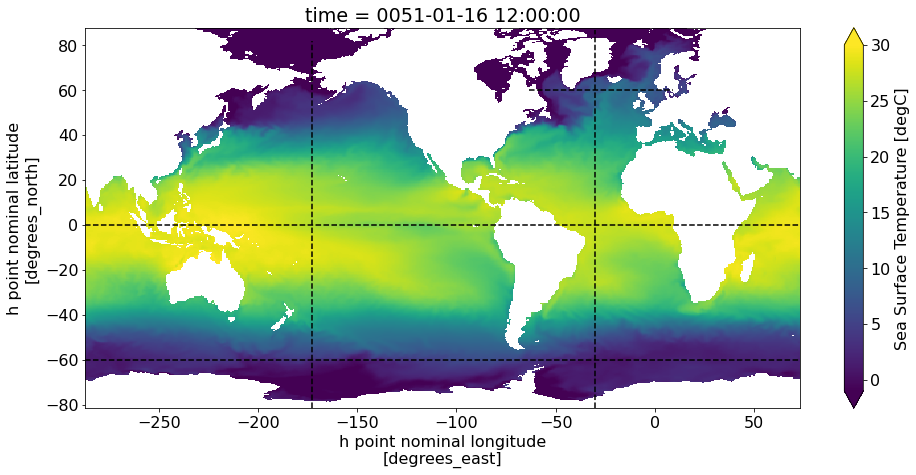

In [7]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16, 7))
da.tos[0,:].plot(ax=ax, vmin=-1, vmax=30)

# prime
val = -173.
geolat = grd_xr[0].geolat.sel(xh=val, method='nearest')
yh = extrapCoord(geolat.values)
xh = np.ones(len(yh)) * val
ax.plot(xh,yh,'k--')

# meridional Atlantic
val = -30.
geolat = grd_xr[0].geolat.sel(xh=val, method='nearest')
yh = extrapCoord(geolat.values)
xh = np.ones(len(yh)) * val
ax.plot(xh,yh,'k--')

# zonal Southern Ocean
val = -60.
xh = extrapCoord(grd_xr[0].geolon.sel(yh=val, method='nearest').values)
yh = np.ones(len(xh)) * val
ax.plot(xh,yh,'k--')

# Equator
val = -0.
xh = extrapCoord(grd_xr[0].geolon.sel(yh=val, method='nearest').values)
yh = np.ones(len(xh)) * val
ax.plot(xh,yh,'k--')

# N Atlantic zonal
val = 60
xh = extrapCoord(grd_xr[0].geolon.sel(yh=val, method='nearest').sel(xh=slice(-60,5)).values)
yh = np.ones(len(xh)) * val
ax.plot(xh,yh,'k--')

In [8]:
def section_plot(xCoord, yCoord, zData, var, time, fname, reg, vmin=10, vmax=500, 
                 zmin=-6000, zmax=0, xlabel='Latitude' ,show=False):
  matplotlib.rcParams.update({'font.size': 16})  
  # Plotting the vertical section
  fig, ax = plt.subplots(figsize=(16, 7))

  # Use plt.pcolormesh to create the plot
  cb = ax.pcolormesh(xCoord, yCoord, zData, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
  ax.plot(xCoord, yCoord.T, 'k', lw=0.5);
  ax.set_ylabel('Depth [m]')
  ax.set_xlabel(xlabel)
  ax.set_title('{}, {} ({}) at {}'.format(reg, var.long_name, var.units, time))
  ax.set_ylim(zmin, zmax)
  plt.tight_layout()
  plt.colorbar(cb, fraction=.08)    
  plt.savefig(fname, dpi=150, transparent=True)
  if not show:
    plt.close()

  return

In [9]:
def combine_ffmpeg_command(sourcefolder, moviename, framerate, frame_pattern, ffmpeg_options):
    # we need `-y` because i can not properly diagnose the errors here...
    dummy = '/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg'
    command = dummy + ' -r %i -i "%s" -y %s -r %i "%s"' % (
        framerate,
        os.path.join(sourcefolder, frame_pattern),
        ffmpeg_options,
        framerate,
        os.path.join(sourcefolder, moviename),
    )
    return command

In [10]:
def check_ffmpeg_version():
    #dummy = '/glade/u/apps/dav/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'
    dummy = '/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg'
    p = Popen(dummy + " -version", stdout=PIPE, shell=True)
    #p = Popen("ffmpeg -version", stdout=PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    # Parse version
    if p_status != 0:
        print("No ffmpeg found")
        return None
    else:
        # parse version number
        try:
            found = re.search("ffmpeg version (.+?) Copyright", str(output)).group(1).replace(" ", "")
            return found
        except AttributeError:
            # ffmpeg version, Copyright not found in the original string
            found = None
    return found

In [11]:
def check_ffmpeg_execute(command, verbose=False, error=False):
    if check_ffmpeg_version() is None:
        raise RuntimeError(
            "Could not find an ffmpeg version on the system. \
        Please install ffmpeg with e.g. `conda install -c conda-forge ffmpeg`"
        )
    else:
        try:
            print(command)
            p = execute_command(command, verbose=verbose, error=error)
            return p
        except RuntimeError:
            raise RuntimeError(
                "Something has gone wrong. Use `verbose=True` to check if ffmpeg displays a problem"
            )
    return

In [12]:
def execute_command(command, verbose=False, error=False):
    p = Popen(command, stdout=PIPE, stderr=STDOUT, shell=True)

    if verbose:
        while True:
            out = p.stdout.read(1)
            out_check = out.decode()
            if out_check == "" and p.poll() is not None:
                break
            if out_check != "":
                # only display 10 lines, this cant be that hard?
                sys.stdout.write(out)
                sys.stdout.flush()
    else:
        p.wait()
    if error:
        if p.returncode != 0:
            raise RuntimeError("Command %s failed" % command)
    return p

In [13]:
def combine_frames_into_movie(
    sourcefolder,
    moviename,
    frame_pattern="frame_%05d.png",
    remove_frames=True,
    verbose=False,
    ffmpeg_options="-c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p",
    framerate=10,
):

    command = combine_ffmpeg_command(sourcefolder, moviename, framerate, frame_pattern, ffmpeg_options)
    print(command)
    p = check_ffmpeg_execute(command, verbose=verbose)

    print("Movie created at %s" % (moviename))
    if remove_frames:
        rem_name = frame_pattern.replace("%03d", "*")
        for f in glob.glob(os.path.join(sourcefolder, rem_name)):
            if os.path.exists(f):
                os.remove(f)
    return p

### Prime

In [14]:
var = 'h' # 'agessc'
val = -173.
reg = 'prime'
label = 'lon = {}'.format(val)

geolat = grd_xr[0].geolat.sel(xh=val, method='nearest')
yh = extrapCoord(geolat.values)
for t in range(len(da.time)):
#for t in range(4):
  data = da[var].isel(time=t).sel(xh=val, method='nearest')
  elev = da.e.isel(time=t).sel(xh=val, method='nearest')
  xCoord, yCoord, zData = section2quadmesh(yh, elev.fillna(0).values, data.values, representation='pcm')
  fname='sections/%s_%s_%03d.png'%(casename[n],var,t)
  # Plotting the vertical section
  section_plot(xCoord, yCoord, zData, da[var], data.time.values, fname, label, 
               vmin=10, vmax=500, zmin=-6000, zmax=0, show=False)
    
mov_name = '%s_%s_%s.mov'%(casename[n],var,reg)
pattern = '%s_%s_'%(casename[n],var)+'%03d.png'
combine_frames_into_movie('sections', mov_name, pattern)

/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg -r 10 -i "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_%03d.png" -y -c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p -r 10 "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_prime.mov"
/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg -r 10 -i "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_%03d.png" -y -c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p -r 10 "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_prime.mov"
Movie created at g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_prime.mov


<Popen: returncode: 0 args: '/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg ...>

### Equator

In [15]:
val = -0.
xh = extrapCoord(grd_xr[0].geolon.sel(yh=val, method='nearest').values)
yh = np.ones(len(xh)) * val
ax.plot(xh,yh,'k--')


var = 'h' # 'agessc'
val = -0.
reg = 'equator'
label = 'lat = 0'

geolon = grd_xr[0].geolon.sel(yh=val, method='nearest')
xh = extrapCoord(geolon.values)
for t in range(len(da.time)):
#for t in range(4):
  data = da[var].isel(time=t).sel(yh=val, method='nearest')
  elev = da.e.isel(time=t).sel(yh=val, method='nearest')
  xCoord, yCoord, zData = section2quadmesh(xh, elev.fillna(0).values, data.values, representation='pcm')
  fname='sections/%s_%s_%03d.png'%(casename[n],var,t)
  # Plotting the vertical section
  section_plot(xCoord, yCoord, zData, da[var], data.time.values, fname, label, 
               vmin=2, vmax=50, zmin=-1000, zmax=0, xlabel='Longitude', show=False)
  #section_plot(xCoord, yCoord, zData, da[var], data.time.values, fname, label, 
  #             vmin=10, vmax=250, xlabel='Longitude', show=False)
    
mov_name = '%s_%s_%s.mov'%(casename[n],var,reg)
pattern = '%s_%s_'%(casename[n],var)+'%03d.png'
combine_frames_into_movie('sections', mov_name, pattern)

/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg -r 10 -i "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_%03d.png" -y -c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p -r 10 "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_equator.mov"
/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg -r 10 -i "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_%03d.png" -y -c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p -r 10 "sections/g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_equator.mov"
Movie created at g.e23_a16g.GJRAv4.TL319_t232_hycom1_N75.2024.008_h_equator.mov


<Popen: returncode: 0 args: '/glade/u/apps/casper/23.10/opt/view/bin/ffmpeg ...>